<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Logo_DuocUC.svg/2560px-Logo_DuocUC.svg.png' width=50%, height=20%>

# Evaluacion Nº1 Deep Learning
## Integrantes: Fabiola Betancourt , Javier Auspont 
## Sección: 003D

# Introducción

En este trabajo se implementa una red neuronal artificial del tipo MLP (Multilayer Perceptron) utilizando TensorFlow/Keras. El objetivo es resolver un problema de clasificación de imágenes usando un subconjunto del conjunto de datos CIFAR. Se busca construir, entrenar y evaluar un modelo capaz de clasificar correctamente las imágenes en sus respectivas categorías, explorando diversas configuraciones de red y técnicas de optimización para mejorar su desempeño.

Objetivo del modelo: crear un clasificador con red neuronal MLP para identificar correctamente 12 clases.

# Carga y Preprocesamiento de Datos

En esta sección se realiza la carga del conjunto de datos, la transformación de sus dimensiones para adecuarlo al formato esperado por TensorFlow, la codificación de las etiquetas y la separación en conjuntos de entrenamiento y validación. Esto permite preparar los datos para ser utilizados en una red neuronal.

Tenemos como estrategia para conseguir el mejor rendimiento realizar lo siguiente para poder ajustar de mejor manera el modelo mas adelante:
* Se dividieron los datos en un 70% de entrenamiento, 15% de validacion y 15% de test.
* Se hizo data augmentation para poder aumentar la robustez del modelo
* Utilizamos Keras Tuner para encontrar automaticamente los mejores hiperparametros
* Agregamos callbacks para permitir una buena convergencia.

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

In [1]:
data = np.load("cifar_subset_tf.npz")
X = np.transpose(data['images'], (0,2,3,1))
y = data['labels']

# Mapear etiquetas a un rango de [0,11]
unique = np.unique(y)
mapping = {lab:i for i, lab in enumerate(unique)}
y_mapped = np.vectorize(mapping.get)(y)

# Convertir etiquetas a one-hot
lb = LabelBinarizer()
y_onehot = lb.fit_transform(y_mapped)

# División de datos: 70% entrenamiento, 15% validación, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_onehot, test_size=0.30, stratify=y_mapped, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42
)
print(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Shapes -> Train: (2450, 32, 32, 3), Val: (525, 32, 32, 3), Test: (525, 32, 32, 3)


Aqui podemos ver varios valores, tenemos 2450 imagenes para entrenamiento, 525 para validacion y 525 para test, como podemos ver todas las imagenes son de 32x32 pixeles y estas cuentan con 3 canales, siendo estos RGB, utilizados para dar color a imagenes digitales.

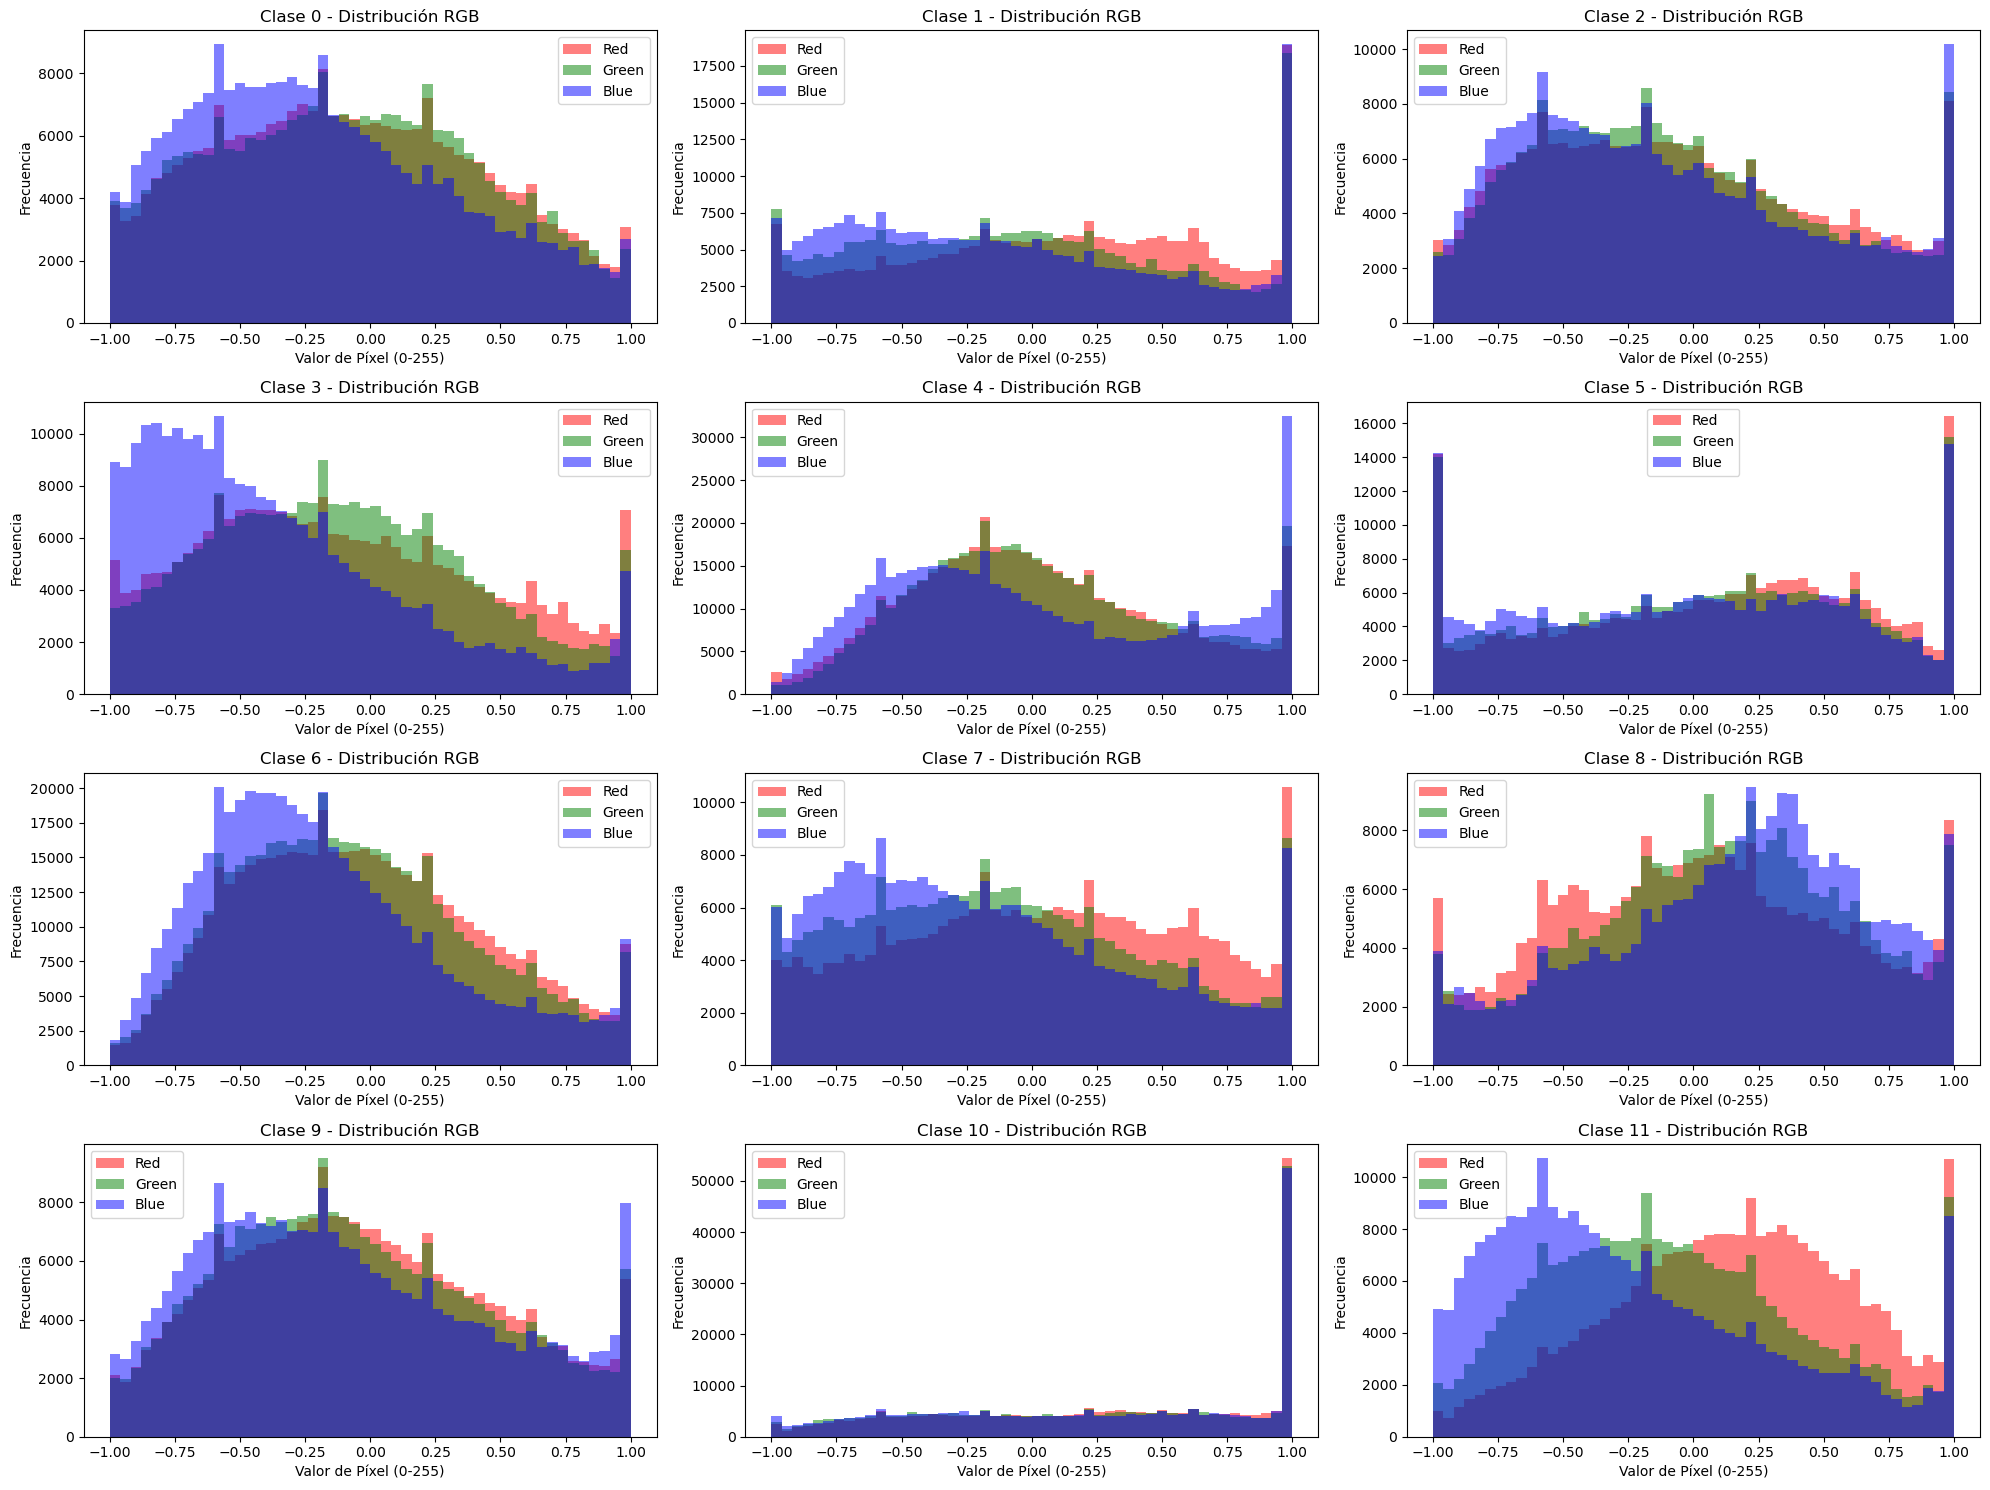

In [45]:
# Histogramas de canales RGB por clase
unique_classes = np.unique(y_mapped)
plt.figure(figsize=(20, 15))
for i, class_id in enumerate(unique_classes):
    plt.subplot(4, 3, i+1)
    class_mask = (y_mapped == class_id)
    class_images = X[class_mask]
    r = class_images[..., 0].flatten()  # Canal Rojo
    g = class_images[..., 1].flatten()  # Canal Verde
    b = class_images[..., 2].flatten()  # Canal Azul
    plt.hist(r, bins=50, color='red', alpha=0.5, label='Red')
    plt.hist(g, bins=50, color='green', alpha=0.5, label='Green')
    plt.hist(b, bins=50, color='blue', alpha=0.5, label='Blue')
    plt.title(f'Clase {class_id} - Distribución RGB')
    plt.xlabel('Valor de Píxel (0-255)')
    plt.ylabel('Frecuencia')
    plt.legend()
plt.tight_layout()
plt.show()

Aqui podemos ver la distribucion de cada capa en todas las clases del dataset, podemos ver que la mayoria sigue una forma similar, pero hay ciertas clases como la 10, 5 y 1 las cuales tienen una distribucion extraña que podria luego traer problemas en las predicciones del modelo.

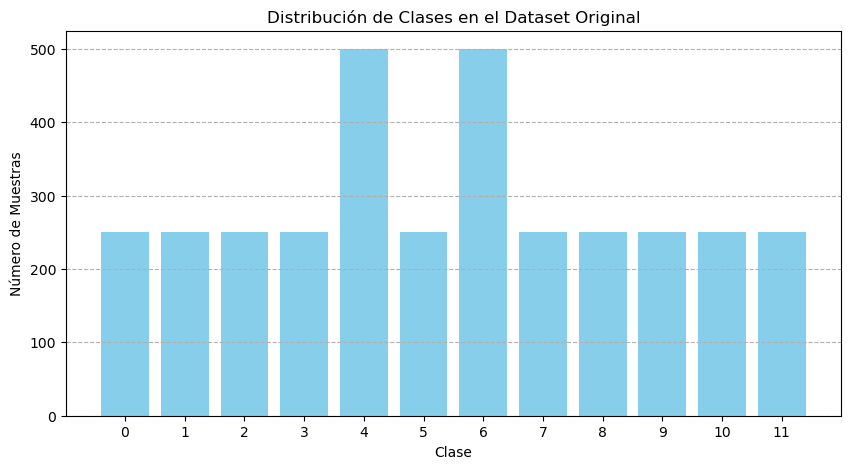

Muestras por clase:
Clase 0: 250 muestras
Clase 1: 250 muestras
Clase 2: 250 muestras
Clase 3: 250 muestras
Clase 4: 500 muestras
Clase 5: 250 muestras
Clase 6: 500 muestras
Clase 7: 250 muestras
Clase 8: 250 muestras
Clase 9: 250 muestras
Clase 10: 250 muestras
Clase 11: 250 muestras


In [48]:
# Contar muestras por clase
classes, counts = np.unique(y_mapped, return_counts=True)

# Gráfico de distribución
plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color='skyblue')
plt.xticks(classes)
plt.title('Distribución de Clases en el Dataset Original')
plt.xlabel('Clase')
plt.ylabel('Número de Muestras')
plt.grid(axis='y', linestyle='--')
plt.show()

# Mostrar valores numéricos
print("Muestras por clase:")
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Aqui podemos ver como es la distribucion en terminos de cantidad de muestras que tenemos para cada clase, en este caso notablemente tenemos mas muestras para la clase 4 y 6 y menos para el resto de clases, esto justifica el uso de data augmentation para poder asi aumentar el muestreo de las clases e intentar mejorar la prediccion futura del modelo.

A continuacion utilizaremos data augmentation para poder aumentar la muestra de datos, de esta forma podemos contar con mas parametros para el entrenamiento, esperando asi que la presicion del modelo sea mayor, luego separamos los datos de entrenamiento y datos de validacion y testeo, estos dos ultimos no cuentan con data augmentation debido a que esto podria nublar el criterio del modelo al momento de predecir fotos, por lo que estos solo se extraen desde las imagenes originales del dataset.

In [2]:
# Creamos una secuencia de aumentos que simulan variaciones naturales en imágenes
batch_size = 64
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Dataset de entrenamiento con aumentos aplicados en cada epoch
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(1000)
            .map(lambda x, y: (augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

# Datasets de validación y test sin aumento
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)


# Entrenamiento y Ajuste de Hiperparámetros

Configuramos una funcion la cual Keras Tuner utilizara para probar distintas configuraciones de capas, activaciones, numero de unidades, tasas de dropout y aprendizaje, con el objetivo de generar el mejor modelo posible.

In [3]:
def build_mlp(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=(32,32,3)))  # Normalización de píxeles
    for i in range(hp.Int('n_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=128, max_value=512, step=64)
        model.add(tf.keras.layers.Flatten() if i == 0 else tf.keras.layers.Dense(units, activation=None))
        model.add(tf.keras.layers.Dense(units, activation=hp.Choice('activation', ['relu','tanh'])))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(12, activation='softmax'))  # Salida con 12 clases
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

A continuacion, generamos la busqueda de hiperparametros.

In [4]:
print("Iniciando búsqueda de hiperparámetros...")
tuner = kt.RandomSearch(
    build_mlp,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='mlp_cifar'
)
tuner.search(train_ds, epochs=20, validation_data=val_ds,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Mostrar mejores hiperparámetros encontrados
tuner.results_summary()
best_hps = tuner.get_best_hyperparameters(1)[0]
print("\nMejores hiperparámetros encontrados:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")


Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.5219047665596008

Best val_accuracy So Far: 0.5352380871772766
Total elapsed time: 00h 01m 20s
Results summary
Results in tuner_dir\mlp_cifar
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
n_layers: 1
units_0: 512
activation: relu
dropout_0: 0.2
lr: 0.003630043814722362
units_1: 320
dropout_1: 0.4
units_2: 512
dropout_2: 0.30000000000000004
Score: 0.5352380871772766

Trial 09 summary
Hyperparameters:
n_layers: 2
units_0: 384
activation: relu
dropout_0: 0.4
lr: 0.0005301182854479577
units_1: 256
dropout_1: 0.2
units_2: 256
dropout_2: 0.4
Score: 0.5219047665596008

Trial 03 summary
Hyperparameters:
n_layers: 2
units_0: 128
activation: relu
dropout_0: 0.2
lr: 0.002841876631465565
units_1: 448
dropout_1: 0.2
units_2: 320
dropout_2: 0.4
Score: 0.508571445941925

Trial 08 summary
Hyperparameters:
n_layers: 3
units_0: 512
activation: relu
dropout_0: 0.30000000000000004
lr: 0.001413190197

Aqui podemos ver una gran cantidad de datos, cada uno de estos llamados "Trial" son entrenamientos que realizo Keras Tuner con el fin de encontrar los mejores hiperparametros para el modelo, en este caso, optamos por los parametros del Trial 06 ya que este dio los mejores resultados en cuanto a accuracy, estos parametros son:
* 1 capa oculta
* 512 unidades con relu
* Dropout de 0.2
* Learning rate de aprox. 0.0036

Esto nos esta sugiriendo que una red poco profunda pero ancha y con regularizacion ligera funciona mejor para este dataset.

In [15]:
# ### 5. Entrenamiento Final con los Mejores Hiperparámetros

# Entrenamos modelo definitivo con los hiperparámetros óptimos
model_opt = tuner.hypermodel.build(best_hps)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
history = model_opt.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/50


C:\Users\FrenchPig\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3095 - loss: 2.1142 - val_accuracy: 0.1429 - val_loss: 2.3699 - learning_rate: 0.0036
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4327 - loss: 1.7525 - val_accuracy: 0.1448 - val_loss: 2.3544 - learning_rate: 0.0036
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4476 - loss: 1.6866 - val_accuracy: 0.1486 - val_loss: 2.3150 - learning_rate: 0.0036
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4778 - loss: 1.6011 - val_accuracy: 0.1810 - val_loss: 2.2822 - learning_rate: 0.0036
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4767 - loss: 1.5928 - val_accuracy: 0.2857 - val_loss: 2.2192 - learning_rate: 0.0036
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5075 - loss: 1.5318 - val_accuracy: 0.3086 - val_loss: 2.1588 - learning_rate: 0.0036
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5124 - loss: 1.4659 - val_accuracy: 0.38

Aqui se puede ver el entrenamiento final del modelo con los hiperparametros conseguidos anteriormente, como se puede notar, este se detuvo en la epoca 29 ya que contamos con un early stopping configurado para detener el entrenamiento en caso de que el modelo no mejore por varias epocas consecutivas, asi prevenimos sobreajuste y ahorramos tiempo de entrenamiento.

In [35]:
model_opt.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,742,694 (18.09 MB)

 Trainable params: 1,580,556 (6.03 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 3,161,114 (12.06 MB)

Aqui podemos ver los parametros del modelo que termino de entrenar.

# Evaluacion del Modelo

En esta seccion realizaremos una evaluacion del modelo, viendo sus resultados con el conjunto de test separado anteriormente

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5592 - loss: 1.3771

Resultados en conjunto de test:
Accuracy: 0.5505
Loss: 1.4034
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.32      0.22      0.26        37
           1       0.35      0.30      0.32        37
           2       0.56      0.39      0.46        38
           3       0.54      0.58      0.56        38
           4       0.73      0.88      0.80        75
           5       0.49      0.45      0.47        38
           6       0.49      0.64      0.55        75
           7       0.39      0.41      0.40        37
           8       0.68      0.71      0.69        38
           9       0.43      0.32      0.37        37
          10       0.75      0.65      0.70        37
          11       0.62      0.63      0.62        38

    accuracy                           0.55       525
   macro avg       0.53      0.51      0.52

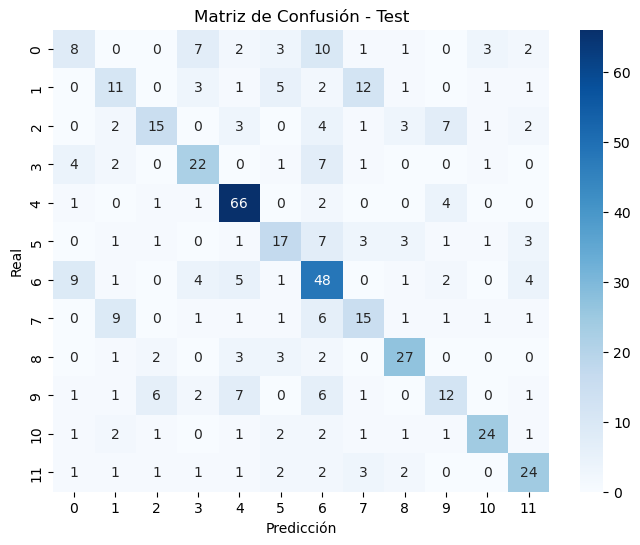

In [17]:
test_loss, test_acc = model_opt.evaluate(test_ds)
print(f"\nResultados en conjunto de test:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Loss: {test_loss:.4f}")

# Reporte detallado por clase
y_pred = np.argmax(model_opt.predict(test_ds), axis=1)
y_true = np.argmax(np.vstack([y for _, y in test_ds]), axis=1)
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, zero_division=0))

# Matriz de confusión visual
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Test')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Aqui podemos ver una matriz de confusion esperada, con la mayoria de la diagonal con los valores mas altos, indicando que, a pesar de no ser 100% correcto, el modelo suele predecir cada clase con su valor esperado, notablemente, la clase 4 es la que mas resultados positivos cuenta.
Ademas, podemos notas que contamos con un accuracy del 0.5505 y un loss del 1.4034, esto significa que el modelo clasifica correctamente almenos el 55% de las imagenes nuevas y que tiene un error promedio de su prediccion de 1.4

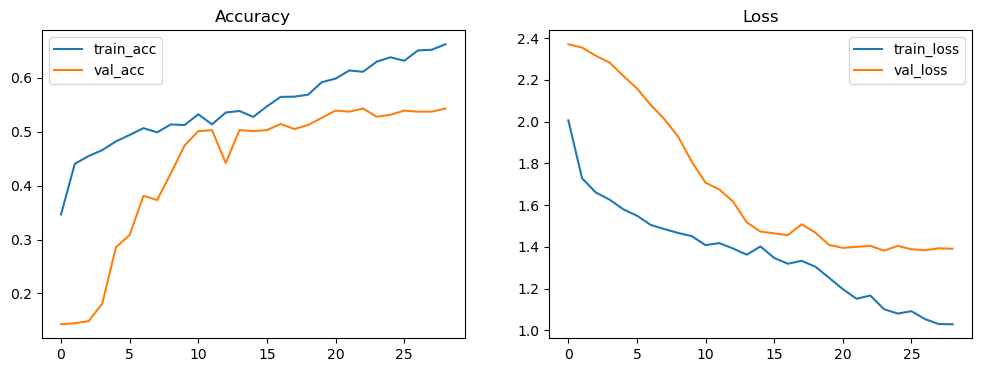

In [19]:
tplt = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(tplt['accuracy'], label='train_acc')
plt.plot(tplt['val_accuracy'], label='val_acc')
plt.legend(), plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(tplt['loss'], label='train_loss')
plt.plot(tplt['val_loss'], label='val_loss')
plt.legend(), plt.title('Loss')
plt.show()


## Accuracy
Podemos notar como el accuracy del entrenamiento y validacion van subiendo a medida que el entrenamiento sube, que es lo esperado, podemos notar que los valores de validacion se comienzan a estancar aproximadamente pasado la epoca 10 y los valores de entrenamiento siguen aumentando sin parar, lo que podria indicar que el modelo estaba tendiendo a hacer overfitting

## Loss
Nuevamente, pero a la inversa, podemos ver como el loss de los dos modelos baja a medida que se entrena, viendo en este caso, un estancamiento en validacion entre las epocas 10 y 15 por lo que dentro de estas epocas es donde se debe encontrar el mejor punto de generalizacion